<a href="https://colab.research.google.com/github/deyabhishek79/MtechProject/blob/main/Automatic_Disney_Photos_Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun 13 09:45:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# New Section

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/
%cp -r Images_Dataset.zip Images_Dataset_colab.zip 

/content/drive/MyDrive


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import glob
 
def load_training_photos(directory):
	images = dict()
	for name in glob.glob(directory):
		# load an image from file
		#filename = directory + '/' + name
		image = load_img(name, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get image id
		image_id = name.split('.')[0]
		images[image_id] = image
	return images
 
# load images
directory = '/content/drive/MyDrive/Images_Dataset/*.jpg'
images = load_training_photos(directory)
print('Loaded Images: %d' % len(images))

Loaded Images: 8145


In [ ]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
import glob
 
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	in_layer = Input(shape=(224, 224, 3))
	model = VGG16(include_top=False, input_tensor=in_layer)
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in glob.glob(directory):
		# load an image from file
		#filename = directory + '/' + name
		image = load_img(name, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
	return features
 
# extract features from all images
directory = '/content/drive/MyDrive/Images_Dataset/*.jpg'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('image_features.pkl', 'wb'))

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# load description into memory
def load_desc_token(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# store the first description for each image
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping
 
filename = '/content/drive/MyDrive/Images_Descriptions/Images.token.txt'
doc = load_desc_token(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8106 


In [ ]:
import string

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# store the first description for each image
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping
 
# clean description text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		# tokenize
		desc = desc.split()
		# convert to lower case
		desc = [word.lower() for word in desc]
		# remove punctuation from each token
		desc = [w.translate(table) for w in desc]
		# remove hanging 's' and 'a'
		desc = [word for word in desc if len(word)>1]
		# store as string
		descriptions[key] =  ' '.join(desc)
 
# save descriptions to file, one per line
def save_doc(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = '/content/drive/MyDrive/Images_Descriptions/Images.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
# save descriptions
save_doc(descriptions, 'descriptions.txt')

Loaded: 8106 
Vocabulary Size: 4507


In [ ]:
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load clean descriptions into memory
def load_clean_descriptions(filename):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# store
		descriptions[image_id] = ' '.join(image_desc)
	return descriptions
 
descriptions = load_clean_descriptions('descriptions.txt')
print('Loaded %d' % (len(descriptions)))
# extract all text
desc_text = list(descriptions.values())
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_text)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# integer encode descriptions
sequences = tokenizer.texts_to_sequences(desc_text)
# pad all sequences to a fixed length
max_length = max(len(s) for s in sequences)
print('Description Length: %d' % max_length)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')
# one hot encode
y = to_categorical(padded, num_classes=vocab_size)
y = y.reshape((len(descriptions), max_length, vocab_size))
print(y.shape)

Loaded 8106
Vocabulary Size: 4508
Description Length: 28
(8106, 28, 4508)


In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.5.0


In [1]:
import string
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Utility Functions

In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [4]:
def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [5]:
filename = '/content/drive/MyDrive/Images_Descriptions/Images.token.txt'
# load descriptions
description_text = load_doc(filename)

In [ ]:
print(description_text[:411])

Aurora.7.jpg#0	Aurora is talking with the squirrel .
Aurora.7.jpg#1	Aurora is speaking with the squirrel .
Aurora.7.jpg#2	Aurora is playing with the squirrel .
Aurora.7.jpg#3	Aurora is singing to the squirrel .
Aurora.7.jpg#4	Aurora is singing to the squirrel and the squirrel is listening .
Anna.1.jpg#0	Anna is smiling at the person .
Anna.1.jpg#1	Anna is feeling happy .
Anna.1.jpg#2	Anna is looking happy .



In [6]:
def create_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [7]:

df = create_dataset(description_text)

In [8]:
df[:10]

[['Aurora.7.jpg', '0', 'aurora is talking with the squirrel .'],
 ['Aurora.7.jpg', '1', 'aurora is speaking with the squirrel .'],
 ['Aurora.7.jpg', '2', 'aurora is playing with the squirrel .'],
 ['Aurora.7.jpg', '3', 'aurora is singing to the squirrel .'],
 ['Aurora.7.jpg',
  '4',
  'aurora is singing to the squirrel and the squirrel is listening .'],
 ['Anna.1.jpg', '0', 'anna is smiling at the person .'],
 ['Anna.1.jpg', '1', 'anna is feeling happy .'],
 ['Anna.1.jpg', '2', 'anna is looking happy .'],
 ['Anna.1.jpg', '3', 'anna is posing happy in the picture .'],
 ['Anna.1.jpg', '4', 'anna is very happy .']]

In [10]:
caption_data = pd.DataFrame(df,columns=["filename","index","caption"])
# Reordering columns for better readability
caption_data = caption_data.reindex(columns =['index','filename','caption'])

In [11]:
caption_data

,index,filename,caption
0,0,Aurora.7.jpg,aurora is talking with the squirrel .
1,1,Aurora.7.jpg,aurora is speaking with the squirrel .
2,2,Aurora.7.jpg,aurora is playing with the squirrel .
3,3,Aurora.7.jpg,aurora is singing to the squirrel .
4,4,Aurora.7.jpg,aurora is singing to the squirrel and the squi...
...,...,...,...
40813,0,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40814,1,997722733_0cb5439472.jpg,a man is rock climbing high in the air .
40815,2,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40816,3,997722733_0cb5439472.jpg,a rock climber in a red shirt .


In [12]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

In [13]:
invalid_filename_check(caption_data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


In [14]:
caption_data[caption_data['filename'] == "2258277193_586949ec62.jpg.1"]

,index,filename,caption
7088,0,2258277193_586949ec62.jpg.1,people waiting for the subway
7089,1,2258277193_586949ec62.jpg.1,some people looking out windows in a large bui...
7090,2,2258277193_586949ec62.jpg.1,three people are waiting on a train platform .
7091,3,2258277193_586949ec62.jpg.1,three people standing at a station .
7092,4,2258277193_586949ec62.jpg.1,two woman and one man standing near train trac...


In [15]:

caption_data = caption_data[caption_data['filename'] != '2258277193_586949ec62.jpg.1']
caption_data.shape

(40813, 3)

In [16]:
image_dir = '/content/drive/MyDrive/Images_Dataset'
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["filename"]:
      full_image_path = image_dir+"/"+ filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector

all_img_name_vector = preprocess_images(caption_data)
all_img_name_vector[:10]

['/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg',
 '/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg',
 '/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg',
 '/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg',
 '/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg',
 '/content/drive/MyDrive/Images_Dataset/Anna.1.jpg',
 '/content/drive/MyDrive/Images_Dataset/Anna.1.jpg',
 '/content/drive/MyDrive/Images_Dataset/Anna.1.jpg',
 '/content/drive/MyDrive/Images_Dataset/Anna.1.jpg',
 '/content/drive/MyDrive/Images_Dataset/Anna.1.jpg']

In [17]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(caption_data)
total_captions[:10]

['<start> aurora is talking with the squirrel . <end>',
 '<start> aurora is speaking with the squirrel . <end>',
 '<start> aurora is playing with the squirrel . <end>',
 '<start> aurora is singing to the squirrel . <end>',
 '<start> aurora is singing to the squirrel and the squirrel is listening . <end>',
 '<start> anna is smiling at the person . <end>',
 '<start> anna is feeling happy . <end>',
 '<start> anna is looking happy . <end>',
 '<start> anna is posing happy in the picture . <end>',
 '<start> anna is very happy . <end>']

In [18]:
ten_images = all_img_name_vector[:50] # Each image repeats 5 times in dataset
unique_images = np.unique(ten_images)
print(unique_images)

['/content/drive/MyDrive/Images_Dataset/Anna.1.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.10.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.2.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.3.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.4.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.5.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.6.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.7.jpg'
 '/content/drive/MyDrive/Images_Dataset/Anna.8.jpg'
 '/content/drive/MyDrive/Images_Dataset/Aurora.7.jpg']


In [19]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

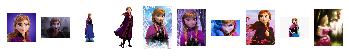

In [20]:
showImagesHorizontally(unique_images)

In [21]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40813
Total Captions : 40813


In [22]:

def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [23]:
train_captions,img_name_vector = data_limiter(40768,total_captions,all_img_name_vector)

In [24]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40768 , Total images = 40768


In [25]:
from pickle import dump

# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [26]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [27]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40768 , Total images = 40768


In [28]:

# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [ ]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [ ]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> content is ==> (333, 500, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 333, 3)
Shape of the image ==> content is ==> (500, 333, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (333, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (333, 500, 3)
Shape of the image ==> content is ==> (354, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (334, 500, 3)
Shape of the image ==> content is ==> (352, 500, 3)
Shape of the image ==> content is ==> (500, 357, 3)
Shape of the image ==> content is ==> (334, 500, 3)
Shape of the image ==> content is ==> (333, 500, 3)
Shape of the image ==> content is ==> (333, 500, 3)
Shape of the image ==> content is ==> (335, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (308, 500, 3)
Shape of the

Shape of the image:(600, 600, 3)


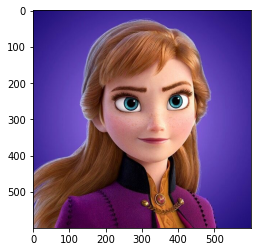

In [29]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes("/content/drive/MyDrive/Images_Dataset/Anna.1.jpg")

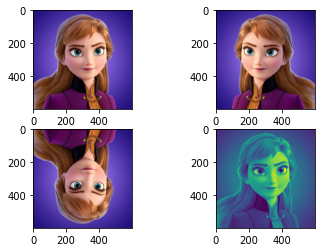

In [31]:
import imageio
import tensorflow as tf
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

image_flipper("/content/drive/MyDrive/Images_Dataset/Anna.1.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


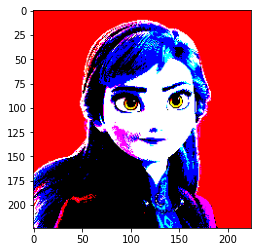

In [32]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image("/content/drive/MyDrive/Images_Dataset/Anna.1.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

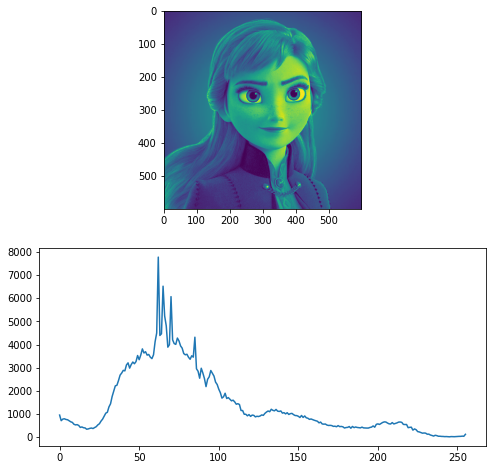

In [33]:
# importing required libraries of opencv 
import cv2 
# importing library for plotting 
from matplotlib import pyplot as plt 
def plot_image_histograms(image): 
  # reads an input image 
  img = cv2.imread(image,0) 
  # find frequency of pixels in range 0-255 
  histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    
  # show the plotting graph of an image 
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr) 
  plt.show() 

plot_image_histograms('/content/drive/MyDrive/Images_Dataset/Anna.1.jpg')

In [ ]:
import tensorflow as tf
modelvgg16 = tf.keras.applications.VGG16(include_top=True,weights=None) 

In [ ]:

modelvgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['/content/drive/MyDrive/Images_Dataset/1000268201_693b08cb0e.jpg', '/content/drive/MyDrive/Images_Dataset/1001773457_577c3a7d70.jpg', '/content/drive/MyDrive/Images_Dataset/1002674143_1b742ab4b8.jpg', '/content/drive/MyDrive/Images_Dataset/1003163366_44323f5815.jpg', '/content/drive/MyDrive/Images_Dataset/1007129816_e794419615.jpg', '/content/drive/MyDrive/Images_Dataset/1007320043_627395c3d8.jpg', '/content/drive/MyDrive/Images_Dataset/1009434119_febe49276a.jpg', '/content/drive/MyDrive/Images_Dataset/1012212859_01547e3f17.jpg', '/content/drive/MyDrive/Images_Dataset/1015118661_980735411b.jpg', '/content/drive/MyDrive/Images_Dataset/1015584366_dfcec3c85a.jpg']


In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

Streaming output truncated to the last 5000 lines.
b'/content/drive/MyDrive/Images_Dataset/287999021_998c2eeb91.jpg'
b'/content/drive/MyDrive/Images_Dataset/2880051254_e0ca96b6be.jpg'
b'/content/drive/MyDrive/Images_Dataset/288025239_5e59ba9c3b.jpg'
b'/content/drive/MyDrive/Images_Dataset/2880874989_a33b632924.jpg'
b'/content/drive/MyDrive/Images_Dataset/2881087519_ca0aa79b2b.jpg'
b'/content/drive/MyDrive/Images_Dataset/2881441125_b580e3dd4b.jpg'
b'/content/drive/MyDrive/Images_Dataset/2881468095_d4ce8c0c52.jpg'
b'/content/drive/MyDrive/Images_Dataset/288177922_b889f2e1fe.jpg'
b'/content/drive/MyDrive/Images_Dataset/2882056260_4399dd4d7c.jpg'
b'/content/drive/MyDrive/Images_Dataset/2882483779_73c171ac19.jpg'
b'/content/drive/MyDrive/Images_Dataset/2882589788_cb0b407a8d.jpg'
b'/content/drive/MyDrive/Images_Dataset/2882743431_c3e6cd1b5c.jpg'
b'/content/drive/MyDrive/Images_Dataset/2882893687_1d10d68f2b.jpg'
b'/content/drive/MyDrive/Images_Dataset/2883099128_0b056eed9e.jpg'
b'/content/dri

In [ ]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
from tqdm import tqdm

In [ ]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    print(path)
    path_of_feature = p.numpy().decode("utf-8")
    print(path_of_feature)
    np.save(path_of_feature, bf.numpy())

NameError: ignored

In [ ]:
np_img =np.load('/content/drive/MyDrive/Images_Dataset/3338291921_fe7ae0c8f8.jpg.npy')

FileNotFoundError: ignored

In [ ]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [ ]:
train_captions[:3]

['<start> four boys play in the mud . <end>',
 '<start> a lone skier walking cross a snowy bank with trees in the background <end>',
 '<start> kids wearing jackets and hats swinging on tire swing in snow <end>']

In [ ]:
train_seqs[:3] # Here we can see that the sentences are converted to sequences


[[3, 121, 98, 90, 5, 6, 378, 4],
 [3, 2, 491, 279, 62, 533, 2, 143, 865, 11, 206, 5, 6, 103, 4],
 [3, 176, 22, 564, 9, 451, 324, 7, 427, 160, 5, 43, 4]]

In [ ]:
tokenizer.oov_token

'<unk>'

In [ ]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'shirt',
 38: 'down',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'snow',
 44: 'child',
 45: 'person',
 46: 'jumping',
 47: 'over',
 48: 'front',
 49: 'three',
 50: 'sitting',
 51: 'holding',
 52: 'up',
 53: 'field',
 54: 'small',
 55: 'her',
 56: 'green',
 57: 'by',
 58: 'large',
 59: 'yellow',
 60: 'one',
 61: 'group',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'its',
 75: 'from',


In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [ ]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 39 : 3


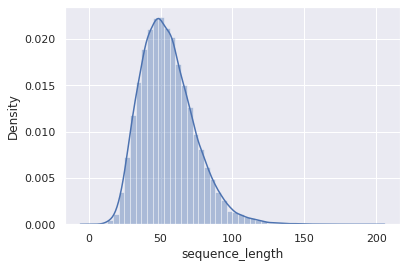

In [ ]:
import seaborn as sns

df=pd.DataFrame()
df["sequence_length"] = caption_data["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

In [ ]:
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector

In [ ]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(40768, 39)


In [ ]:
padded_caption_vector

array([[   3,  121,   98, ...,    0,    0,    0],
       [   3,    2,  491, ...,    0,    0,    0],
       [   3,  176,   22, ...,    0,    0,    0],
       ...,
       [   3,    2, 1367, ...,    0,    0,    0],
       [   3,    2,   58, ...,    0,    0,    0],
       [   3,    6,   12, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [ ]:

print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32614,Y = 32614
Test Data : X = 8154,Y = 8154


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:

def load_npy(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
'''
# How Dataset.from_tensor_slices work
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)   # [1, 2], [3, 4]
ds # <TensorSliceDataset shapes: (2,), types: tf.int32>
'''
def create_dataset(img_name_train,caption_train):

  
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49

In [ ]:
# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
''' To choose score type: 
  Enter 'dot' for dot score
  Enter 'general' for general score
  Enter 'concat' for concat score
'''
def score_choose():
  scoring_type= input('Enter the scoring method: ')
  return scoring_type

In [ ]:
scoring_type=score_choose()

Enter the scoring method: general


In [ ]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
        #For Score 3 i.e. Concat score
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type

        
    def call(self, sequence, features,hidden):
        
        # features : (64,49,256)
        # hidden : (64,512)
        
        embed = self.embedding(sequence)
        # embed ==> (64,1,256) ==> decoder_input after embedding (embedding dim=256)
       
        output, state = self.gru(embed)       
        #output :(64,1,512)

        score=0
        
        #Dot Score as per paper(Dot score : h_t (dot) h_s') (NB:just need to tweak gru units to 256)
        '''----------------------------------------------------------'''
        if(self.scoring_type=='dot'):
          xt=output #(64,1,512)
          xs=features #(256,49,64)  
          score = tf.matmul(xt, xs, transpose_b=True) 
               
          #score : (64,1,49)

        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # General Score as per Paper ( General score: h_t (dot) Wa (dot) h_s')
        '''----------------------------------------------------------'''
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)
          # score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''




        # Concat score as per paper (score: VT*tanh(W[ht;hs']))    
        '''----------------------------------------------------------'''
        #https://www.tensorflow.org/api_docs/python/tf/tile
        if(self.scoring_type=='concat'):
          tiled_features = tf.tile(features, [1,1,2]) #(64,49,512)
          tiled_output = tf.tile(output, [1,49,1]) #(64,49,512)
          
          concating_ht_hs = tf.concat([tiled_features,tiled_output],2) ##(64,49,1024)
          
          tanh_activated = self.wd(concating_ht_hs)
          score =self.Vattn(tanh_activated)
          #score :(64,49,1), but we want (64,1,49)
          score= tf.squeeze(score, 2)
          #score :(64,49)
          score = tf.expand_dims(score, 1)
          
          #score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # alignment :(64,1,49)

        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
        # context : (64,1,256)
        
        # Combine the context vector and the LSTM output
        
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
        # output: concat[(64,1,256):(64,1,512)] = (64,768)

        output = self.wc(output)
        # output :(64,512)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(output)
        # logits/predictions: (64,8239) i.e. (batch_size,vocab_size))

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
''' Type: 'global' for Luong's Attention Mechanism(Global Attention) 
    Type: 'local' for Bahdanau's Attention Mechanism(Local Attention) 
'''
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply :local


In [ ]:
if(attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else:
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)

In [ ]:
decoder

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path_ckpt = "./checkpoint/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# Clear previous logs
!rm -rf ./logs/

In [ ]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)


In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  #train_loss(loss)
  #train_accuracy(target, predictions)

  return loss, total_loss

In [ ]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [ ]:
for epoch in range(start_epoch, 20):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

UnknownError: ignored